# Fluctuation Test

In this notebook, we will simulate a virtual experiment mimicking that of Luria & Delbruck (1943) on bacterial resistance to phage treatment. In this classic experiment, they exposed bacterial cells to phages and measured statistics of the number of resistant cells, in order to test whether these resistant cells emerged in response to the treatment or preexisted before that. In the first scenario, mutations would be induced by phages and happen only after the exposure, whereas in the second scenario, mutations would happen irrespectively of the phages and some cells would have become resistant before being exposed. Their experimental results and statistical analyses confirmed the second scenario, which helped establish that genetic mutations occur randomly, as we now know since they are caused by random alterations of DNA.

Let us recapitulate the method they used to distinguish between those two scenarios. Suppose we have grown a large number $N$ of bacterial cells, and we treat them with phages to find that a small fraction $\mu$ could survive. Therefore, on average we would find $\mu N$ resistant cells. But if we repeat the experiment, the actual number of resistant cells would fluctuate from replicate to replicate. The key point is to measure the variance of such fluctuation and compare it to the mean ($\mu N$). Luria & Delbruck argued that, in the first scenario, the number of resistant cells should have a Poisson distribution and hence the variance should be equal to the mean, whereas in the second scenario, the variance should be much larger than the mean. Their data showed a large variance, thus supporting the second scenario. Because the analyses relied on quantifying the fluctuation of event numbers, their method has become known as the "fluctuation test".

We would like to understand why the two scenarios would have different variance-to-mean ratios. For that purpose, we will simulate the growth of bacterial cells and the occurrence of mutant cells. Remember that in a typical experiment, we start from a single cell and let it grow to a large population by successive cell divisions. For simplicity, we will assume that cells divide synchronously and so the population grows geometrically. We will study the scenarios where resistant mutants appear either after or before the phage exposure.

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

## Scenario 1: resistant cells emerge after exposure

In the first scenario, there are no mutants before the cells are treated with phages. Therefore, cells simply grow in numbers and we need to keep track of the number of cells after a given number of generations. When we treat them with phages, each cell has the same probability $\mu$ of becoming resistant. Here is a Python class that describes such a process.

In [2]:
class MutationAfterExposure:
    """
    simulate the growth of bacterial cells in the scenario where resistant cells appear after exposure.
    """
    
    def __init__(self, mu, N0=1):
        """
        initialize experiment, assuming all cells are normal in the beginning.
        inputs:
        mu: float, probability that a normal cell becomes resistant *after exposure*.
        N0: int, initial number of normal cells.
        """
        self.mu = mu
        self.N = N0    # number of normal cells
        self.M = 0     # number of mutant cells
    
    def grow(self, gen=1):
        """
        grow cells for a given number of generations.
        inputs:
        gen: int, number of generations to grow.
        """
        for g in range(gen):
            self.N = self.N * 2    # cell division doubles their number in every generation
    
    def treat(self):
        """
        treat cells, during which each cell has a fixed probability of becoming resistant.
        """
        # ran = np.random.rand(self.N)    # draw a random number for each cell
        # self.M = np.sum(ran < mu)    # a cell becomes resistant if its random number is less than mu
        """
        The above method becomes computationally unfeasible when `self.N` is very large.
        Instead, we will use an equivalent method knowing that `self.M` obeys the binomial distribution.
        """
        self.M = np.random.binomial(self.N, self.mu)    # draw from a binomial distribution B(N,mu)
        self.N = 0    # non-resistant cells die

Now we can simulate an experiment where we grow the cells "overnight", which can be about 30 generations. This would give us $N = 2^{30} \sim 10^9$ cells. Let us assume that the mutation rate is $\mu = 10^{-7}$. Therefore, on average we should have $\mu N \sim 10^2$ resistant cells.

In [3]:
mae1 = MutationAfterExposure(1e-7)
mae1.grow(gen=30)
print(f'before treatment: number of normal cells = {mae1.N}, number of resistant cells = {mae1.M}')
mae1.treat()
print(f'after treatment: number of normal cells = {mae1.N}, number of resistant cells = {mae1.M}')

before treatment: number of normal cells = 1073741824, number of resistant cells = 0
after treatment: number of normal cells = 0, number of resistant cells = 99


We see that there was no resistant cells before the treatment, consistent with the first scenario. After the treatment, no normal cells survived, and the number of resistant cells is close to what we expected. If we repeat the simulation again, we will get a slightly different number due to random fluctuations. To collect statistics on the numbers, let us repeat the "experiment" many times and calculate the mean and variance.

In [4]:
G = 30    # number of generations to grow
mu = 1e-7    # mutation probability after exposure

repeats = 1000    # number of repeat experiments
results = []    # collect numbers of resistant cells from experiments

for r in range(repeats):
    mae1 = MutationAfterExposure(mu)
    mae1.grow(gen=G)
    mae1.treat()
    results.append(mae1.M)

In [5]:
mean = np.mean(results)    # mean number of resistant cells in an experiment
var = np.var(results)      # variance of number of resistant cells among experiments
ratio = var / mean
print(f'mean number of resistant cells = {mean}')
print(f'variance = {var}')
print(f'variance-to-mean ratio = {ratio}')

mean number of resistant cells = 107.748
variance = 112.04449599999998
variance-to-mean ratio = 1.039875413000705


We see that the variance-to-mean ratio is very close to 1, which signals a Poisson distribution. Mathematically, for $N$ trials with success probability $\mu$ each, the number of successful trials will obey the binomial distribution (which is what we used in the code above). However, for large $N$ and $\mu N \gg 1$, this distribution can be well approximated by a Poisson distribution. Let us plot this distribution.

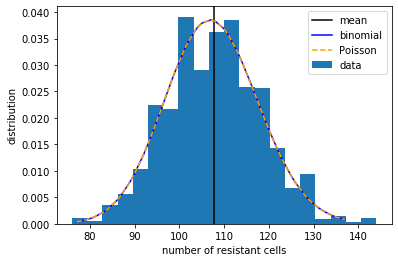

In [6]:
N = 2**G    # number of all cells in an experiment
M = N * mu    # expected number of resistant cells
x_array = np.linspace(M-30, M+30, 41).astype(int)
b_array = st.binom.pmf(x_array, N, mu)    # calculate the binomial probability mass function
p_array = st.poisson.pmf(x_array, M)    # calculate Poisson probability mass function with same mean

plt.figure()
plt.hist(results, bins=20, density=True, label='data')
plt.axvline(mean, color='k', label='mean')
plt.plot(x_array, b_array, color='b', label='binomial')
plt.plot(x_array, p_array, color='orange', linestyle='--', label='Poisson')
plt.xlabel('number of resistant cells')
plt.ylabel('distribution')
plt.legend()
plt.show()

Thus, in the first scenario where resistant cells emerge after exposure, the number of resistant cells from repeat experiments would show a Poisson distribution, having a variance-to-mean ratio close to 1.

## Scenario 2: resistant cells appear before exposure

Now consider the second scenario, where resistant mutants arise spontaneously regardless of the phage. This means that resistant cells can appear anytime during the growth of the bacterial population, even before encountering phages. Let us denote by $\nu$ the probability that a normal cell mutates and becomes resistant during its cell cycle (which can be different from $\mu$ above). Note that, whenever a cell becomes resistant, *all* its descendants will also be resistant. We assume that the resistant cells grow at the same rate as the normal cells, so the population grows geometrically regardless of its composition. To simulate the growth process in this scenario, we need to keep track of the numbers of both normal and resistant cells.

In [7]:
class MutationBeforeExposure:
    """
    simulate the growth of bacterial cells in the scenario where resistant cells can appear anytime before exposure.
    """
    
    def __init__(self, nu, N0=1):
        """
        initialize experiment, assuming all cells are normal in the beginning.
        inputs:
        nu: float, probability that a normal cell becomes resistant *during its generation*.
        N0: int, initial number of normal cells.
        """
        self.nu = nu
        self.N = N0    # number of normal cells
        self.M = 0     # number of mutant cells
    
    def grow(self, gen=1):
        """
        grow cells for a given number of generations.
        inputs:
        gen: int, number of generations to grow.
        """
        for g in range(gen):
            self.N = self.N * 2    # normal cells divide, some may mutate afterwards
            self.M = self.M * 2    # mutant cells divide and all their descendants are resistant
            mutate = np.random.binomial(self.N, self.nu)    # draw a random number of normal cells that mutate
            self.N = self.N - mutate    # update the number of normal cells
            self.M = self.M + mutate    # update the number of mutant cells
    
    def treat(self):
        """
        treat cells, which kills normal cells but does not affect resistant cells.
        """
        self.N = 0    # normal cells are killed

Let us simulate experiments in this scenario, growing cells "overnight" for $G = 30$ generations to have $N = 2^G \sim 10^9$ cells as before. It can be shown that, in the second scenario, the expected number of resistant cells will be $\approx G \nu N$. Therefore, to match the expected number $\mu N$ of resistant cells in the previous simulation, we will use a smaller mutation rate, $\nu = \mu / G \approx 0.33 \times 10^{-8}$.

In [8]:
mbe1 = MutationBeforeExposure(0.33e-8)
mbe1.grow(gen=30)
print(f'before treatment: number of normal cells = {mbe1.N}, number of resistant cells = {mbe1.M}')
mbe1.treat()
print(f'after treatment: number of normal cells = {mbe1.N}, number of resistant cells = {mbe1.M}')

before treatment: number of normal cells = 1073741807, number of resistant cells = 17
after treatment: number of normal cells = 0, number of resistant cells = 17


In this case, there were already resistant cells even before the treatment, and only those survived after the treatment. However, the number of resistant cells is not so close to what we expected, which should be around $G \nu N \sim 10^2$. In fact, if we run the simulation multiple times, we will find that the number of resistant cells fluctuates substantially. To have better statistics on the numbers, we need to repeat the "experiment" many more times (which is impossible for real experiments).

In [9]:
G = 30    # number of generations to grow
nu = 0.33e-8    # mutation probability per normal cell per generation

repeats = 100000    # number of repeat experiments
results = []    # collect numbers of resistant cells from experiments

for r in range(repeats):
    mbe1 = MutationBeforeExposure(nu)
    mbe1.grow(gen=G)
    mbe1.treat()
    results.append(mbe1.M)

In [10]:
mean = np.mean(results)    # mean number of resistant cells in an experiment
var = np.var(results)      # variance of number of resistant cells among experiments
ratio = var / mean
print(f'mean number of resistant cells = {mean}')
print(f'variance = {var}')
print(f'variance-to-mean ratio = {ratio}')

mean number of resistant cells = 64.65265
variance = 2061659.978777977
variance-to-mean ratio = 31888.251738760548


You may be amazed by the incredibly large variance-to-mean ratio in this case. Because of the large fluctuations, our calculated mean number of resistant cells is not that accurate. Let us visualize the large fluctuations by plotting the histogram of the simulation results (in log scale!).

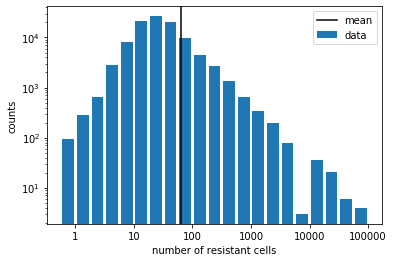

In [11]:
results = np.array(results)
results_nz = results[np.nonzero(results)[0]]    # remove zeros from results so that we can take the log
num_zero = repeats - len(results_nz)    # number of zeros in the original results
bins = np.arange(-0.125, 5, 0.25)    # specify bin edges for histogram
hist = np.histogram(np.log10(results_nz), bins)[0]    # calculate histogram in log scale
hist = np.hstack(([num_zero], hist))    # add back number of zeros into the histogram

xticks = [1, 10, 100, 1000, 10000, 100000]
plt.figure()
plt.bar(bins, hist, width=0.2, label='data')
plt.axvline(np.log10(mean), color='k', label='mean')
plt.xticks(np.log10(xticks), xticks)
plt.xlabel('number of resistant cells')
plt.yscale('log')
plt.ylabel('counts')
plt.legend()
plt.show()

The long tail (again, in log scale!) of the distribution shows that, in some experimental trials, we get a huge number of resistant cells compared to the mean, which contributes to the large variance that we saw above. The exact shape of the distribution is not easy to calculate theoretically. However, it suffices to use the very large variance-to-mean ratio to distinguish this scenario from the first one. Indeed, it was by observing such a large variance-to-mean ratio in their real experiments that Luria & Delbruck (1943) were able to reject the first scenario (mutation after exposure) and establish the second scenario (mutation before exposure). Remember that this was before people knew the molecular structrue of DNA and the cause of mutations!